In [6]:
import os
import json
import numpy as np
import pandas as pd
from archetypal import settings
from pathlib import Path
from ladybug.epw import EPW
from uuid import uuid4
from shoeboxer.builder import ShoeboxConfiguration, ShoeBox
# from shoeboxer.schedules import default_schedules
from utils.constants import *
import torch
from lightning.pytorch import Trainer
from torch.utils.data import DataLoader
from ml.surrogate import Surrogate
from ml.predict import predict_ubem
from weather.weather import extract

# Check if we are running on Windows or Linux using os
if os.name == "nt":
    settings.ep_version == "22.2.0"
    settings.energyplus_location = Path("C:/EnergyPlusV22-2-0")
else:
    settings.ep_version == "22.2.0"
    settings.energyplus_location = Path("/usr/local/EnergyPlus-22-2-0")

In [7]:
registry = "ml-for-building-energy-modeling/model-registry"
model = "Global UBEM Shoebox Surrogate with Combined TS Embedder"
tag = "v3"
resource = "model.ckpt"

surrogate = Surrogate.load_from_registry(registry, model, tag, resource)
surrogate.model.eval()

trainer = Trainer(
        accelerator="auto",
        devices="auto",
        strategy="auto",
        enable_progress_bar=True,
    )

c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'target_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['target_transform'])`.
c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'weather_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['weather_transform'])`.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, u

## Test version

In [8]:
# Get grasshopper json data for config
gh_data_dir = "D:/DATA/SingleShoeboxTests/Shoebox.json"
# gh_data_dir = "D:/DATA/SingleShoeboxTests/Shoebox_sched3.json"
with open(gh_data_dir, 'r') as f:
    gh_data = json.load(f)

In [9]:
gh_data["ShoeboxConfig"]["orientation"]

0.0

In [10]:
epw_path = "C:/ProgramData/Solemma/Common/WeatherData/EPW/USA_MA_Boston-Logan.Intl.AP.725090_TMYx.2004-2018.epw"
# epw_path ="C:/ProgramData/Solemma/Common/WeatherData/EPW/USA_NY_New.York-LaGuardia.AP.725030_TMYx.2004-2018.epw"
if gh_data["Conditioning"]["HeatRecoveryType"] == "None":
    hrv = 0
else:
    hrv = HRV[gh_data["Conditioning"]["HeatRecoveryType"]].value 
if "occ" in gh_data["Conditioning"]["MechVentSchedule"].lower():
    vent_mode = 2
else:
    vent_mode = 0 #TODO
rval = 4.88
config = {
    "FacadeMass": 0, #TODO
    "RoofMass": 0,
    "FacadeRValue": rval,
    "RoofRValue": rval,
    "SlabRValue": rval,
    "WindowUValue": gh_data["SimpleWindow"]["uval"],
    "WindowShgc": gh_data["SimpleWindow"]["shgc"],
    "PeopleDensity": gh_data["Loads"]["PeopleDensity"],
    "EquipmentPowerDensity": gh_data["Loads"]["EquipmentPowerDensity"],
    "LightingPowerDensity": gh_data["Loads"]["LightingPowerDensity"],
    "HeatingSetpoint": gh_data["Conditioning"]["HeatingSetpoint"],
    "CoolingSetpoint": gh_data["Conditioning"]["CoolingSetpoint"],
    "cop_heating": 1,
    "cop_cooling": 1,
    "VentilationMode": vent_mode,
    "VentilationPerArea": gh_data["Conditioning"]["MinFreshAirArea"]/1000,
    "VentilationPerPerson": gh_data["Conditioning"]["MinFreshAirPerson"]/1000,
    "EconomizerSettings": Econ[gh_data["Conditioning"]["EconomizerType"]].value,
    "RecoverySettings": hrv,
    "Infiltration": gh_data["Infiltration"]["InfiltrationFlowPerExteriorSurfaceArea"],
    "wwr": gh_data["ShoeboxConfig"]["wwr"],
    "roof_2_footprint": gh_data["ShoeboxConfig"]["roof_2_footprint"],
    "ground_2_footprint": gh_data["ShoeboxConfig"]["ground_2_footprint"],
    "orientation": gh_data["ShoeboxConfig"]["orientation"],
    "width": gh_data["ShoeboxConfig"]["width"],
    "height": gh_data["ShoeboxConfig"]["height"],
    "perim_depth": gh_data["ShoeboxConfig"]["perim_depth"],
    "core_depth": gh_data["ShoeboxConfig"]["core_depth"],
    "building_idx": 0,
    "edge_length": 1,
    "edge_weight": 1,
    "weight": 1,
    "template_idx": 0.0,
    "floor_name": "none",
}

In [11]:
"""
Make Schedules
"""
schedules = pd.read_hdf("data/schedules.h5")
idx = gh_data["ShoeboxConfig"]["schedule_index"]
print(idx)
scheds = schedules.loc[schedules.index[idx*3][0]].to_numpy()

0


In [12]:
"""
Make Shoebox
"""
sb_config = ShoeboxConfiguration()
sb_config.width = config["width"]
sb_config.height = config["height"]
sb_config.adiabatic_partition_flag = 0
sb_config.perim_depth = config["perim_depth"]
sb_config.core_depth = config["core_depth"]
sb_config.wwr = config["wwr"]
sb_config.roof_2_footprint = config["roof_2_footprint"]
sb_config.ground_2_footprint = config["ground_2_footprint"]
sb_config.shading_vect = np.zeros(12)
sb_config.orientation = config["orientation"]
template_dict = config.copy()
template_dict["schedules"] = scheds

sb = ShoeBox(
    name=str(uuid4()),
    epw=epw_path,
    shoebox_config=sb_config,
    template_dict=template_dict,
    output_directory="data/sim_results/"
)
idf = sb.idf(run_simulation=False)

"""
Simulate
"""

hourly_df, monthly_df = sb.simulate(idf=idf)
df = sb.postprocess(monthly_df)
annual = df.T.groupby(level=[0,1]).sum().T
annual

INFO:shoeboxer.geometry_utils:New perimeter depth: 3.0
INFO:shoeboxer.geometry_utils:New core depth: 7.0
INFO:shoeboxer.geometry_utils:Shifting core origin to perimeter edge; moving -2.0 m in y axis
INFO:shoeboxer.geometry_utils:Updating adiabatic surfaces.
INFO:shoeboxer.geometry_utils:Maximum shading point is 0.0
INFO:shoeboxer.geometry_utils:Placing shading around center point [1.5 0. ]
INFO:ShoeBox:Building idf for data\sim_results\bb335e3c-836f-439c-acac-18c7c3f86f00.epjson
INFO:ShoeBox:EnergyPlus Starting
INFO:ShoeBox:EnergyPlus, Version 22.2.0-c249759bad, YMD=2023.11.20 22:16


INFO:ShoeBox:Converted input file format. Exiting.
INFO:ShoeBox:EnergyPlus Run Time=00hr 00min  0.11sec
INFO:ShoeBox:Command executed successfully.
C:\EnergyPlusV22-2-0\ExpandObjects.EXE #0-bb335e3c-836f-439c-acac-18c7c3f86f00.idf: 3.00it [00:00, 15.8it/s]
C:\EnergyPlusV22-2-0\energyplus.exe bb335e3c-836f-439c-acac-18c7c3f86f00.idf: 56it [00:05, 11.02it/s]


KeyValue   Name   
Core       Cooling    32.484302
           Heating     0.010037
Perimeter  Cooling    83.525474
           Heating     1.318321
dtype: float64

In [13]:
# core, heating, cooling
out_file = gh_data_dir.split(".json")[0] + "_whitebox_out.csv"
print(out_file)
np.savetxt(out_file, np.resize(df.to_numpy(), (4,12)), delimiter=",")


D:/DATA/SingleShoeboxTests/Shoebox_whitebox_out.csv


In [14]:
climate = extract(EPW(epw_path))
for i in range(12):
    config[f"shading_{i}"] = 0
features = pd.DataFrame(data=config, index=[0])

In [15]:
from ml.data import PredictBuildingDataset

dataset = PredictBuildingDataset(features, np.expand_dims(scheds, 0),climate, surrogate.space_config)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
shoebox_predictions = trainer.predict(surrogate, dataloader)
shoebox_predictions = torch.cat(shoebox_predictions)
try:
    shoebox_predictions = shoebox_predictions.cpu().numpy()
except:
    shoebox_predictions = shoebox_predictions.numpy()
shoebox_predictions[shoebox_predictions <= 0] = 0
shoebox_predictions = pd.DataFrame(
    shoebox_predictions,
    columns=surrogate.target_transform.columns,
)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.06it/s]

c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:1009.)
  return F.conv1d(input, weight, bias, self.stride,


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]


In [16]:
import plotly.express as px
print(annual)
print(shoebox_predictions.T.groupby(level=[0,1]).sum().T)

KeyValue   Name   
Core       Cooling    32.484302
           Heating     0.010037
Perimeter  Cooling    83.525474
           Heating     1.318321
dtype: float64
KeyValue       Core           Perimeter        
Name        Cooling Heating     Cooling Heating
0         39.945717     0.0  107.665611     0.0


In [17]:
# core, heating, cooling
out_file = gh_data_dir.split(".json")[0] + "_surrogate_out.csv"
print(out_file)
np.savetxt(out_file, np.resize(shoebox_predictions.to_numpy(), (4,12)), delimiter=",")

D:/DATA/SingleShoeboxTests/Shoebox_surrogate_out.csv


In [18]:
# Load idf from 
cs_idf = gh_data_dir.split(".json")[0] + ".idf"

### Check geom

In [19]:
from archetypal import IDF
cs_idf = IDF(cs_idf)

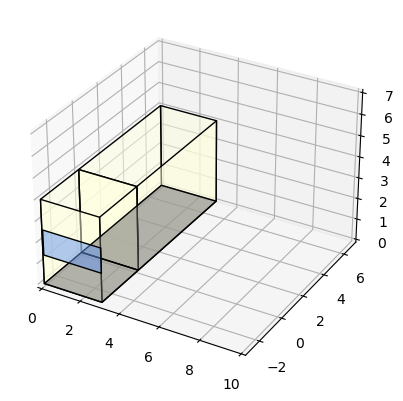

(<Figure size 640x480 with 1 Axes>, [<Axes3D: >])

In [20]:
cs_idf.view_model()

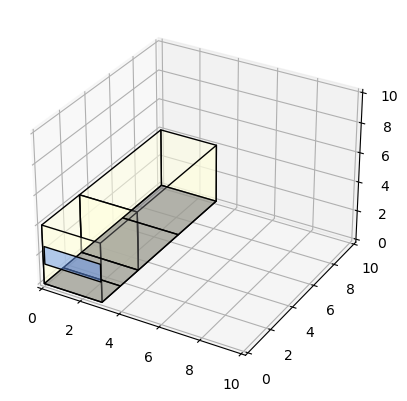

(<Figure size 640x480 with 1 Axes>, [<Axes3D: >])

In [21]:
idf.view_model()

In [22]:
scheds.shape

(3, 8760)

### Check Scheds

In [23]:
from archetypal.schedule import Schedule
reference_schedules = np.load("./data/schedules.npy")

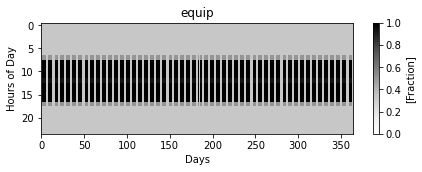

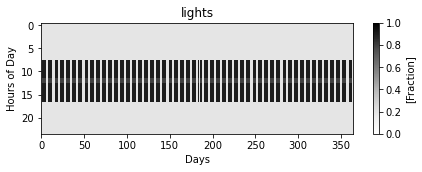

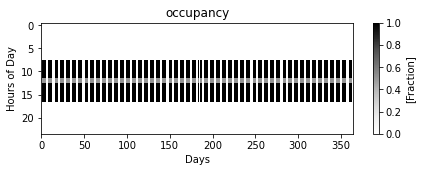

(<Figure size 504x144 with 2 Axes>,
 <Axes: title={'center': 'occupancy'}, xlabel='Days', ylabel='Hours of Day'>)

In [32]:
idx = 10
scheds = schedules.loc[schedules.index[idx*3][0]].to_numpy()
Schedule.from_values(Name="equip", Values=scheds[0]).plot2d()
Schedule.from_values(Name="lights", Values=scheds[1]).plot2d()
Schedule.from_values(Name="occupancy", Values=scheds[2]).plot2d()

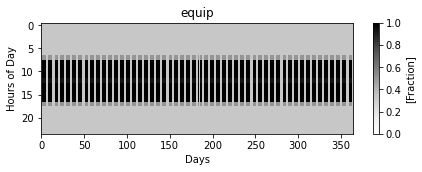

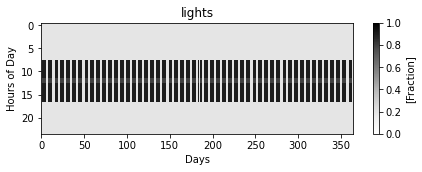

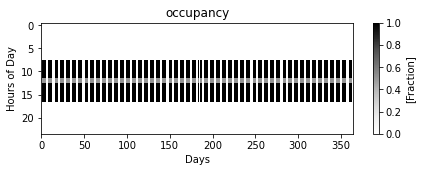

(<Figure size 504x144 with 2 Axes>,
 <Axes: title={'center': 'occupancy'}, xlabel='Days', ylabel='Hours of Day'>)

In [33]:
Schedule.from_values(Name="equip", Values=reference_schedules[idx][0]).plot2d()
Schedule.from_values(Name="lights", Values=reference_schedules[idx][1]).plot2d()
Schedule.from_values(Name="occupancy", Values=reference_schedules[idx][2]).plot2d()